In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [3]:
db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "RISHI@garv1222",
                             database = "target_ecommerce"
                            )
cur = db.cursor()

## List all unique cities where customers are located.

In [5]:
query = ''' SELECT distinct(customer_city) FROM customers'''

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


## Count the number of orders placed in 2017

In [7]:
query = ''' SELECT COUNT(order_id) FROM orders WHERE year(order_purchase_timestamp) = 2017'''

cur.execute(query)

data = cur.fetchall()
"The total number of orders placed in 2017 are", data[0][0]

('The total number of orders placed in 2017 are', 45101)

## Find the total sales per category.

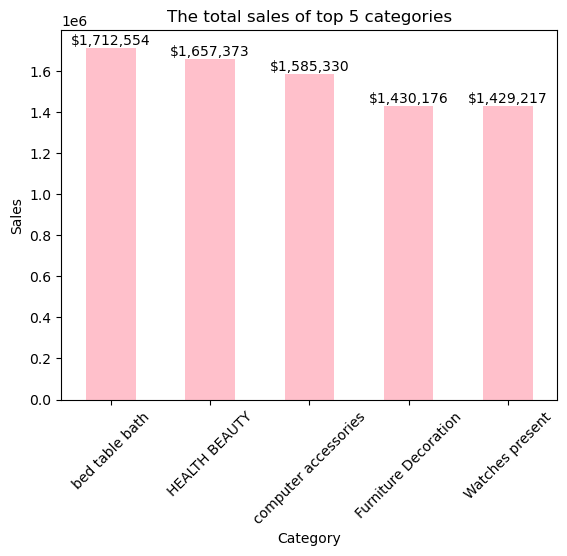

In [9]:
query = ''' SELECT products.product_category as Category, round(sum(payments.payment_value),2) as Sales
FROM products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
GROUP BY Category
ORDER BY Sales DESC'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Category', 'Sales'])
df = df.set_index('Category')
top5 = df.head(5)

# Create the bar plot
ax = top5.plot(kind='bar',color = 'pink', legend=False)

# Add labels on top of each bar
for p in ax.patches:
    ax.annotate(f'${p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')
    
plt.title("The total sales of top 5 categories")
plt.ylabel('Sales')
plt.xlabel("Category")
plt.xticks(rotation = 45)
plt.show()


## Calculate the percentage of orders that were paid in installments

In [11]:
query = ''' SELECT (sum(case when payment_installments >= 1 then 1 else 0 end))/count(order_id)*100 
FROM payments'''

cur.execute(query)

data = cur.fetchall()
"The percentage of orders that were paid in installments is", data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

## Count the number of customers from each state.

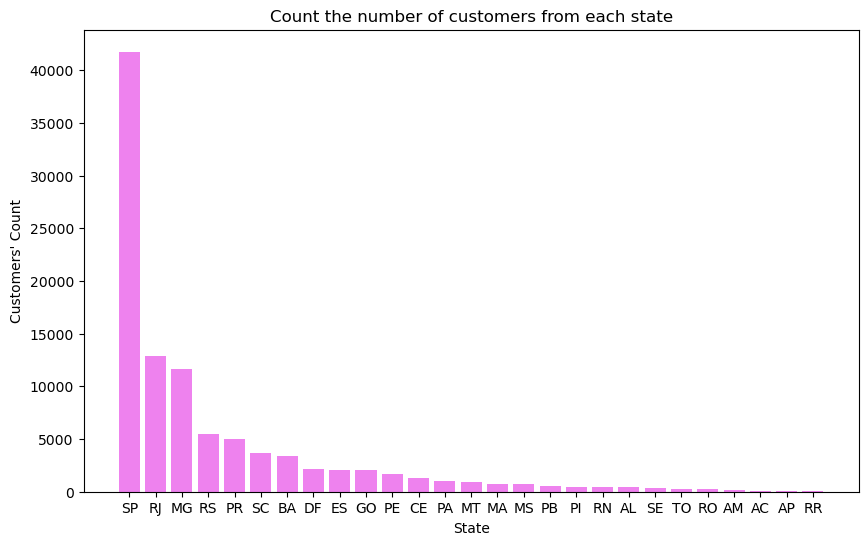

In [13]:
query = ''' SELECT customer_state, COUNT(customer_unique_id) as count FROM customers
GROUP BY customer_state ORDER BY count DESC'''

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['State','Count'])

plt.figure(figsize = (10,6))
plt.bar(df['State'],df['Count'], color = "Violet")
plt.title("Count the number of customers from each state")
plt.xlabel("State")
plt.ylabel("Customers' Count")
plt.show()

## Calculate the number of orders per month in 2018.

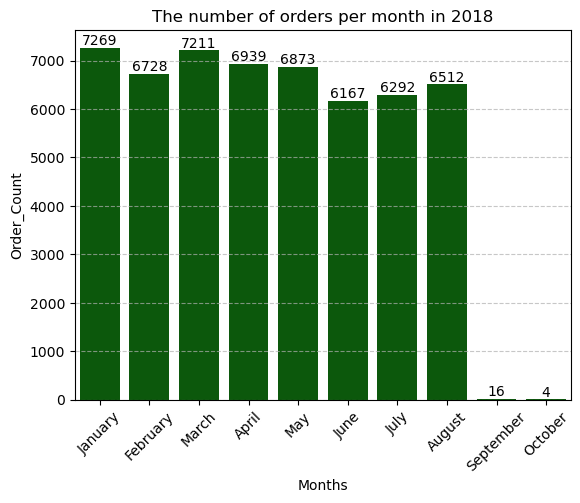

In [15]:
query = ''' SELECT month(order_purchase_timestamp)month_num, monthname(order_purchase_timestamp) months, COUNT(order_id) Count
FROM orders WHERE year(order_purchase_timestamp) = 2018
GROUP BY months, month_num
ORDER BY month_num'''

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Month_num','Month_Name', 'Order_Count'])

ax = sns.barplot(x=df['Month_Name'],y=df['Order_Count'],data = df, color = "darkgreen")
ax.bar_label(ax.containers[0])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.title("The number of orders per month in 2018")
plt.xlabel("Months")
plt.ylabel("Order_Count")
plt.xticks(rotation = 45)
plt.show()

## Find the average number of products per order, grouped by customer city.

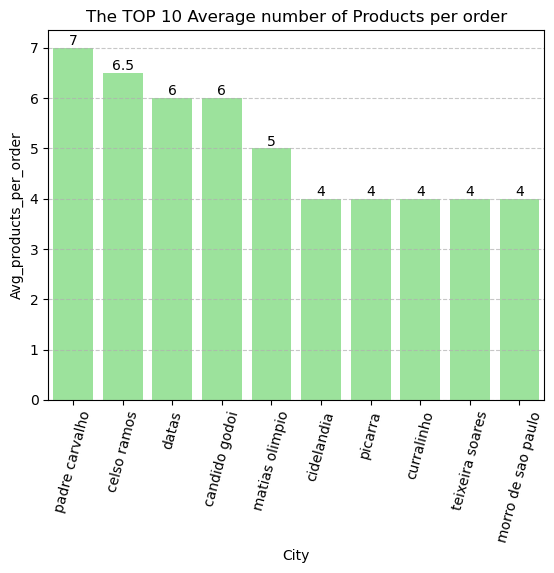

In [17]:
query = '''select order_summary.customer_city, round(avg(order_summary.order_product_count),2) as avg_products_per_order 
from ( select orders.order_id,customers.customer_id,customers.customer_city, count(order_items.product_id)
AS order_product_count
    FROM orders JOIN order_items 
    ON orders.order_id = order_items.order_id
    JOIN customers
    ON orders.customer_id = customers.customer_id
    GROUP BY orders.order_id, customers.customer_id, customers.customer_city
) AS order_summary
GROUP BY order_summary.customer_city
ORDER BY avg_products_per_order DESC;'''

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Customer_City', 'Avg_products_per_order'])

top10 = df.head(10)

ax = sns.barplot(x=top10['Customer_City'],y= top10['Avg_products_per_order'],data = top10, color = "lightgreen")
ax.bar_label(ax.containers[0])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.title("The TOP 10 Average number of Products per order")
plt.xlabel("City")
plt.ylabel("Avg_products_per_order")
plt.xticks(rotation = 75)
plt.show()

## Calculate the percentage of total revenue contributed by each product category.

In [19]:
query = '''SELECT  revenue_table.product_category,
    round(SUM(revenue_table.product_count * revenue_table.price) * 100 / 
    (SELECT SUM(order_items.price) FROM order_items),2) AS revenue_percentage
FROM ( SELECT COUNT(order_items.product_id) AS product_count,
    order_items.price, products.product_category
    from order_items JOIN products
    ON order_items.product_id = products.product_id
    GROUP BY products.product_category,order_items.price,products.product_id
    ) as revenue_table
GROUP BY revenue_table.product_category
ORDER BY revenue_percentage DESC;'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns =['Product_Category','Total_Revenue_Percentage'])
df

,Product_Category,Total_Revenue_Percentage
0,HEALTH BEAUTY,9.26
1,Watches present,8.87
2,bed table bath,7.63
3,sport leisure,7.27
4,computer accessories,6.71
...,...,...
69,flowers,0.01
70,House Comfort 2,0.01
71,cds music dvds,0.01
72,Fashion Children's Clothing,0.00


## Identify the correlation between product price and the number of times a product has been purchased.

Correlation between Purchase_count and Avg_Price: -0.0321
p-value is:5.3648e-09


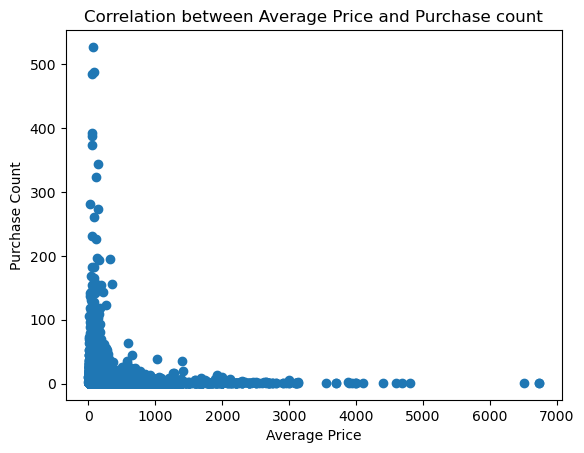

In [21]:
query = '''SELECT 
    oi.product_id,
    COUNT(*) AS purchase_count,
    round(AVG(oi.price),2) AS avg_price
FROM 
    order_items oi
GROUP BY 
    oi.product_id
ORDER BY purchase_count DESC;'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Product_ID','Purchase_count','Avg_Price'])

from scipy.stats import pearsonr

# calculate the pearson corelation
correlation, p_value = pearsonr(df['Purchase_count'], df['Avg_Price'])

print(f"Correlation between Purchase_count and Avg_Price: {correlation:.4f}")
print(f"p-value is:{p_value:.4e}")

plt.scatter(x=df['Avg_Price'], y=df['Purchase_count'])
plt.title("Correlation between Average Price and Purchase count")
plt.xlabel("Average Price")
plt.ylabel("Purchase Count")
plt.show()

## Calculate the total revenue generated by each seller, and rank them by revenue.

In [23]:
query = '''SELECT seller_id, round(SUM(price),2) as total_revenue,
DENSE_RANK() OVER (ORDER BY SUM(price) DESC) AS revenue_rank
FROM order_items
group by seller_id
order by total_revenue DESC;'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Seller_ID','Total_Revenue','Rank'])

df = df.head()
df

,Seller_ID,Total_Revenue,Rank
0,4869f7a5dfa277a7dca6462dcf3b52b2,229472.63,1
1,53243585a1d6dc2643021fd1853d8905,222776.05,2
2,4a3ca9315b744ce9f8e9374361493884,200472.92,3
3,fa1c13f2614d7b5c4749cbc52fecda94,194042.03,4
4,7c67e1448b00f6e969d365cea6b010ab,187923.89,5


## Calculate the moving average of order values for each customer over their order history.

In [27]:
query = '''SELECT orders.customer_id, orders.order_purchase_timestamp, payments.payment_value, 
round(AVG(payments.payment_value) 
OVER (partition by orders.customer_id ORDER BY orders.order_purchase_timestamp ROWS BETWEEN 2 PRECEDING AND CURRENT ROW),2)
AS Moving_Avg
FROM orders JOIN payments
ON orders.order_id = payments.order_id;'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Customer_ID','Order_Purchase_Timestamp','Payments','Moving_Avg'])
df = df.head(10)
df

,Customer_ID,Order_Purchase_Timestamp,Payments,Moving_Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.80
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.40
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.59
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.23
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.71


## Calculate the cumulative sales per month for each year.

   Year  Month Month_Name      Sales  Cumulative_Sales       date
0  2016      9  September     267.36            267.36 2016-09-01
1  2016     10    October   49507.66          49775.02 2016-10-01
2  2016     12   December      10.90          49785.92 2016-12-01
3  2017      1    January  120312.87         170098.79 2017-01-01
4  2017      2   February  247303.02         417401.81 2017-02-01


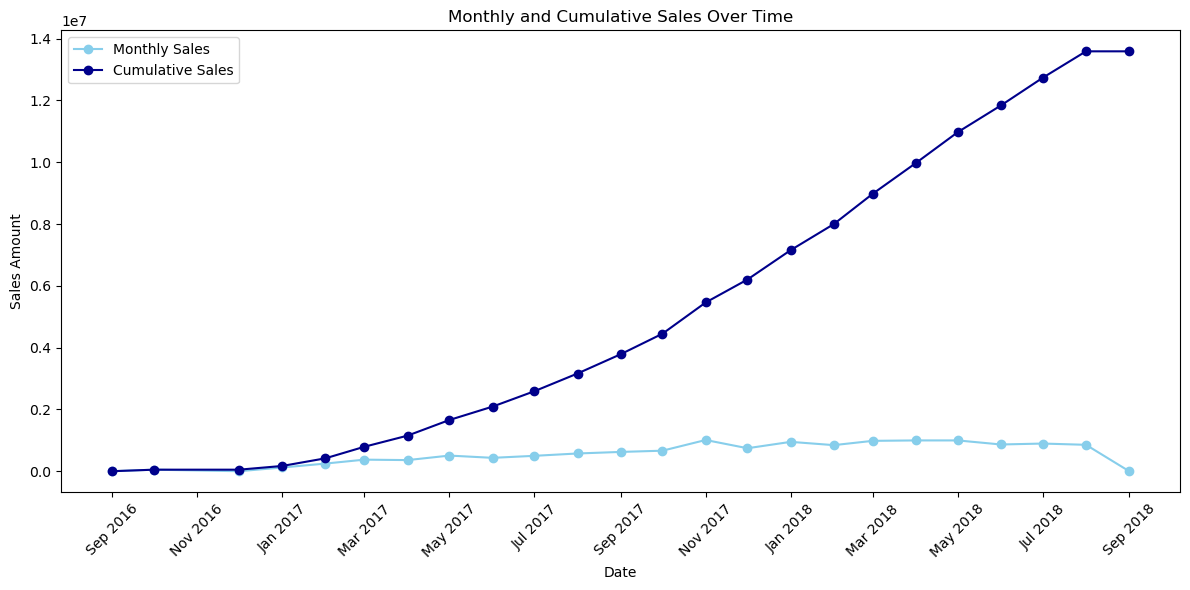

In [65]:
query = '''SELECT year(orders.order_purchase_timestamp) as Years,
month(orders.order_purchase_timestamp) as Months,
monthname(orders.order_purchase_timestamp) as Month_Name,
round(sum(order_items.price),2) as Sales,
round(sum(sum(order_items.price)) OVER (ORDER BY YEAR(orders.order_purchase_timestamp),
month(orders.order_purchase_timestamp)),2) AS Cumulative_Sales
from orders join order_items
on orders.order_id = order_items.order_id
group by Years, Months, Month_Name
order by Years, Months;'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Year','Month','Month_Name','Sales','Cumulative_Sales'])

#create a proper datetime column if needed
df['date']= pd.to_datetime(df['Year'].astype(str)+'-'+df['Month'].astype(str).str.zfill(2)+'-01')

print(df.head())

# plot
plt.figure(figsize=(12,6))

# monthly sales
plt.plot(df['date'], df['Sales'], marker ='o',label='Monthly Sales', color ='skyblue')

# cumulative sales
plt.plot(df['date'], df['Cumulative_Sales'], marker= 'o', label= 'Cumulative Sales', color = 'darkblue')


#Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.title('Monthly and Cumulative Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

## Calculate the year-over-year growth rate of total sales.

   Year  Total_Sales  Prev_Year_Sales  YOY_Growth_%
0  2016     49785.92              NaN           NaN
1  2017   6155806.98         49785.92      12264.55
2  2018   7386050.80       6155806.98         19.99


C:\Users\DELL\AppData\Local\Temp\ipykernel_26660\3876790797.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data =df, x='Year', y = 'YOY_Growth_%', palette = 'Blues')


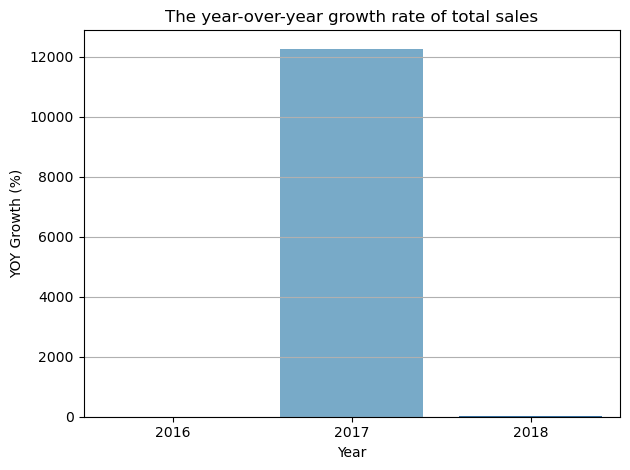

In [73]:
query = '''WITH yearly_sales AS(
SELECT YEAR(orders.order_purchase_timestamp) AS Year,
round(SUM(order_items.price),2) AS total_sales
FROM orders JOIN order_items
ON orders.order_id = order_items.order_id
GROUP BY YEAR(orders.order_purchase_timestamp)
),
Sales_with_growth AS (
SELECT Year, total_sales,
LAG(total_sales) OVER (ORDER BY Year) AS previous_year_sales
FROM yearly_sales
)
SELECT Year, total_sales, previous_year_sales,
ROUND((total_sales - previous_year_sales)/ NULLIF( previous_year_sales,0)*100,2)
AS YOY_growth_percentage
FROM Sales_with_growth;'''

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Year','Total_Sales','Prev_Year_Sales','YOY_Growth_%'])

print(df)
# plot
ax = sns.barplot(data =df, x='Year', y = 'YOY_Growth_%', palette = 'Blues')
ax.bar_label(ax.containers[0], fmt='%.1f%%')
plt.title("The year-over-year growth rate of total sales")
plt.xlabel("Year")
plt.ylabel("YOY Growth (%)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [82]:
query = '''WITH first_order AS(SELECT customer_id ,MIN(order_purchase_timestamp) AS first_purchase
FROM orders
GROUP BY customer_id
),
next_order AS (SELECT orders.customer_id, 
MIN(orders.order_purchase_timestamp) AS next_purchase
FROM orders join first_order
ON orders.customer_id = first_order.customer_id
WHERE orders.order_purchase_timestamp > first_order.first_purchase
AND orders.order_purchase_timestamp <= DATE_ADD(first_order.first_purchase , INTERVAL 6 MONTH)
GROUP BY orders.customer_id
)
SELECT
ROUND((SELECT COUNT(*) FROM next_order) * 100.0 /
(SELECT COUNT(*) FROM first_order),2) AS Retention_Rate_percentage;'''

cur.execute(query)

data = cur.fetchall()

"No repeated customer is available",data[0][0]

('No repeated customer is available', Decimal('0.00'))

# Identify the top 3 customers who spent the most money in each year.

In [85]:
query = '''SELECT Years, customer_id, payment, Rank_given 
FROM 
(SELECT YEAR(orders.order_purchase_timestamp) AS Years,
orders.customer_id,
ROUND(SUM(payments.payment_value),2) AS payment,
DENSE_RANK() OVER (partition by YEAR(orders.order_purchase_timestamp) ORDER BY SUM(payments.payment_value)DESC) AS RANK_given
FROM orders JOIN payments
ON orders.order_id = payments.order_id
GROUP BY Years , orders.customer_id) AS a
WHERE RANK_given <= 3;'''

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Year','Customer_ID','Payment','Rank'])
df

,Year,Customer_ID,Payment,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.55,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.74,2
2,2016,4a06381959b6670756de02e07b83815f,1227.78,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.08,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.31,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.88,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.21,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,3
